In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join  


In [6]:
df =  pd.read_csv('plz.csv', header=0, encoding='cp949')

df.columns

Index(['시군산지', '연도', '월', '시점', '일자', '품목', '품종', '광역산지', '도매가격.원.kg.',
       '거래량.톤.', '거래금액.백만원.', '마늘.면적..ha.', 'X10a당.생산량..kg.', '생산량..톤.',
       'X10a당.생산량.톤', '평균', '평균기온..C.', '평균상대습도...', '월합강수량.00.24h만..mm.',
       '합계.일조시간.hr.'],
      dtype='object')

Text(0, 0.5, 'price')

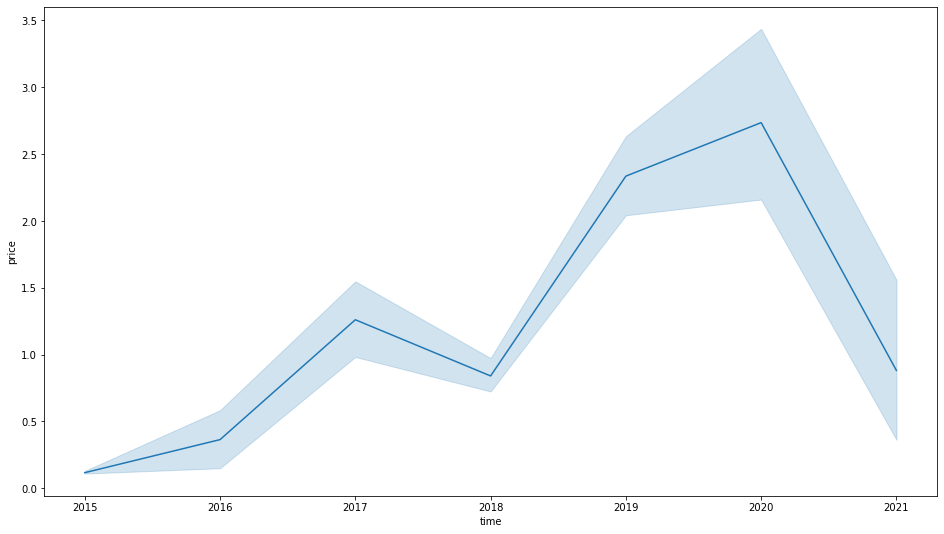

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['거래금액.백만원.'], x=df['연도'])
plt.xlabel('time')
plt.ylabel('price')

# 데이터정규화

In [8]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['도매가격.원.kg.',
       '거래량.톤.', '거래금액.백만원.', '마늘.면적..ha.', 'X10a당.생산량..kg.', '생산량..톤.',
       'X10a당.생산량.톤', '평균', '평균기온..C.', '평균상대습도...', '월합강수량.00.24h만..mm.']

df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)

df_scaled.columns = scale_cols

df_scaled

,도매가격.원.kg.,거래량.톤.,거래금액.백만원.,마늘.면적..ha.,X10a당.생산량..kg.,생산량..톤.,X10a당.생산량.톤,평균,평균기온..C.,평균상대습도...,월합강수량.00.24h만..mm.
0,0.055862,0.004013,0.002716,0.000000,0.179661,0.000000,0.179661,0.012338,0.407295,0.298246,0.037746
1,0.186951,0.002984,0.005262,0.634328,0.000000,0.380125,0.000000,0.017403,0.629179,0.614035,0.147880
2,0.207001,0.002984,0.006394,0.634328,0.000000,0.380125,0.000000,0.017403,0.629179,0.614035,0.147880
3,0.172054,0.000103,0.000170,0.634328,0.000000,0.380125,0.000000,0.017403,0.629179,0.614035,0.147880
4,0.187129,0.001955,0.003282,0.634328,0.000000,0.380125,0.000000,0.017403,0.629179,0.614035,0.147880
...,...,...,...,...,...,...,...,...,...,...,...
1446,0.137792,0.205680,0.296950,0.417910,1.000000,0.711605,1.000000,0.718992,0.474164,0.333333,0.018226
1447,0.137792,0.102788,0.148418,0.417910,1.000000,0.711605,1.000000,0.718992,0.474164,0.333333,0.018226
1448,0.137792,0.205680,0.296950,0.417910,1.000000,0.711605,1.000000,0.718992,0.689970,0.666667,0.135600
1449,0.065038,0.002984,0.001867,0.417910,1.000000,0.711605,1.000000,0.718992,0.860182,0.807018,0.276370


In [36]:
TEST_SIZE = 200
WINDOW_SIZE = 100

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [45]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [46]:
from sklearn.model_selection import train_test_split

feature_cols = ['거래량.톤.', '거래금액.백만원.', '마늘.면적..ha.', 'X10a당.생산량..kg.', '생산량..톤.',
       'X10a당.생산량.톤', '평균', '평균기온..C.', '평균상대습도...', '월합강수량.00.24h만..mm.']
label_cols = ['도매가격.원.kg.']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((984, 20, 10), (247, 20, 10))

In [47]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 10), (200, 1))

In [48]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 10), (180, 1))

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [50]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
62/62 [==============================] - 2s 12ms/step - loss: 0.0174 - val_loss: 0.0080

Epoch 00001: val_loss improved from inf to 0.00796, saving model to model\tmp_checkpoint.h5
Epoch 2/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0072

Epoch 00002: val_loss improved from 0.00796 to 0.00721, saving model to model\tmp_checkpoint.h5
Epoch 3/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0070

Epoch 00003: val_loss improved from 0.00721 to 0.00703, saving model to model\tmp_checkpoint.h5
Epoch 4/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0072

Epoch 00004: val_loss did not improve from 0.00703
Epoch 5/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0074

Epoch 00005: val_loss did not improve from 0.00703
Epoch 6/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0068

Epoch 00006: 

In [43]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape


(180, 1)

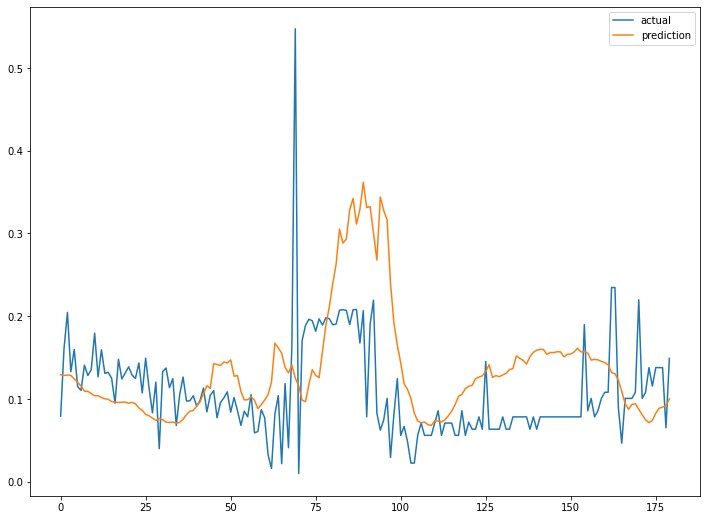

In [51]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()


In [54]:
print("test_predict", pred[0])
print("Tomorrow's stock price", pred[0]) # 예측한 주가를 출력한다

test_predict [0.12915678]
Tomorrow's stock price [0.12915678]
